**PROJETO CASE – Engenheiro de Analytics**

---

Projeto que aborda os conhecimentos práticos em SQL, Modelagem, SSIS, Python e compreensão dos dados e suas abordagens.

  

As entregas deste projeto estão divididos em:

  

1. Script SQL:

**script criacao tabelas.sql**

Script SQL responsável por criar as tabelas DIMENSÕES, FATO e STAGE e criando suas primary keys e foreign keys.

  

2. Pack de importação:

**Projeto PTrans-Desepesas.ispac**

Pack do projeto para importação no SQL SERVER.

  

3. Projeto SSIS:

Folder **Integration Services Project1**:

Folder contendo o projeto SSIS para visualição de sua implementação. Nele também há uma pasta contendo o script em Python (getDatas.py) que é usado pelo SSIS para fazer as requisições REST API no Portal da Transparência.

---

**Sobre a implementação:**

  

![image do projeto SSIS](ssis.png)

  

<br>Após a análise dos dados, projetou-se a modelagem do banco de dados (script SQL) e iniciou-se a implementação SSIS.
<br>Como o Portal da Transparência faz requisições REST à algum serviço interno, usando a "ferramenta de desenvolvimento" do navegador, viu-se a API que é chamada. Assim, criou-se um script Python que faz as requisições ao serviço. Este script, por sua vez, é chamado de dentro do SSIS pelo "Execute Process Task" que salva os dados em arquivo CSV e, então, os dados são populados em uma **STAGE**.
<br>Uma vez os dados persistidos no banco de dados, os novos dados são gravados nas **Dimensões** (é usando um script SQL com o comando *MERGE...WHEN NOT MATCHED*).
<br>Quando o processo das Dimensões é concluído é executado o processo que popula a tabela **Fato** usando o mesmo procedimento anterior.

---
<br>
Preparação de ambiente e Leitura do Dataset

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

In [2]:
# nomes das colunas para serem lidas do arquivo
colsGROUP = ['Ano e mês do lançamento',
        'Nome Órgão Superior',
        'Nome Elemento de Despesa']
colsSUM = ['Valor Liquidado (R$)',
          'Valor Pago (R$)']

# nomes das colunas depois de renomeadas
newColsGROUP = ['AnoMes', 'OrgaoSup', 'Despesa']
newColSUM = ['VlLiq', 'VlPago']

In [3]:
# Determina o modo de exibição das casas decimais
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# ler todos os arquivos CSV da pasta (de Jan à Out)
PASTA = './despesas'
csv_files = glob.glob(PASTA + '/*.csv')

df = pd.concat(
        (pd.read_csv(arquivo, on_bad_lines='skip', sep=';', 
                     usecols=colsGROUP + colsSUM,
                     decimal=",",
                     thousands="."
                     ) for arquivo in csv_files), 
        ignore_index=True)

# renomeia as colunas
df = df.rename(columns=dict(zip(colsGROUP+colsSUM, 
                                newColsGROUP+newColSUM)))

In [4]:
# removendo linhas quando Valor Líquido e Pago forem zero.
df.drop(df.loc[(df['VlLiq']==0) & (df['VlPago']==0)].index, inplace=True)

Para a análise, optou-se por analisar o total de despesas previstas (VlLiq) vs o total de despesas liberadas (VlPago). Ou seja, quanto o Governo Federal reservou (previa) e quanto, de fato, liberou.
<br>Exibindo uma amostra dos dados.

In [5]:
df.head()

,AnoMes,OrgaoSup,Despesa,VlLiq,VlPago
4,2022/01,Ministério da Economia,Material de Consumo,2000.00,2000.00
9,2022/01,Ministério da Educação,Despesas de Exercícios Anteriores,124.91,0.00
12,2022/01,Ministério das Relações Exteriores,Outros Serviços de Terceiros - Pessoa Física,19286.64,17406.19
18,2022/01,Ministério da Justiça e Segurança Pública,Auxílio-Transporte,252214.25,0.00
21,2022/01,Ministério do Trabalho,Pensões do RPPS e do militar,389463.28,66482.10


In [6]:
df[df['OrgaoSup'].isin(['Ministério da Cidadania',
                        'Ministério da Educação',
                        'Ministério da Mulher, Família e Direitos Huma',
                        'Ministério da Saúde',
                        'Ministério do Desenvolvimento Regional'
                        ])]

,AnoMes,OrgaoSup,Despesa,VlLiq,VlPago
9,2022/01,Ministério da Educação,Despesas de Exercícios Anteriores,124.91,0.00
24,2022/01,Ministério da Educação,Contratação por Tempo Determinado,8035.81,0.00
31,2022/01,Ministério da Educação,Sentenças Judiciais,561127.81,0.00
35,2022/01,Ministério da Educação,Obrigações Patronais,163386.66,163386.66
54,2022/01,Ministério da Educação,Despesas de Exercícios Anteriores,36.14,36.14
...,...,...,...,...,...
587606,2022/10,Ministério da Educação,Auxílio Financeiro a Estudantes,800.00,3600.00
587623,2022/10,Ministério da Educação,Serviços de Tecnologia da Informação e Comuni,54.00,108.00
587624,2022/10,Ministério da Educação,Auxílio Financeiro a Pesquisadores,0.00,34980.00
587627,2022/10,Ministério da Educação,Outros Serviços de Terceiros - Pessoa Jurídic,8468.00,4478.00


Gráfico com Valor Previsto (VlLiq) vs Valor Liberado (VlPago).
Vê-se que há uma liberação total do valor previsto - mesmo que isso se reflita em outros meses.

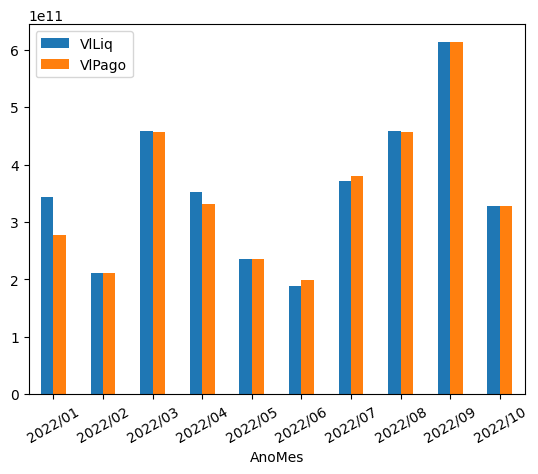

In [7]:
df.groupby('AnoMes').sum().reset_index().\
    plot(x='AnoMes', y=['VlLiq', 'VlPago'], kind="bar", rot=30)

plt.show()

Observa-se que há um contante aumento na liberação para o Ministério das Comunicações.
O que fez dobrar a verba? Houve aumento proporcional entre todas as despensas deste Ministério ou foi direcionado para um(ns) específico(s)?

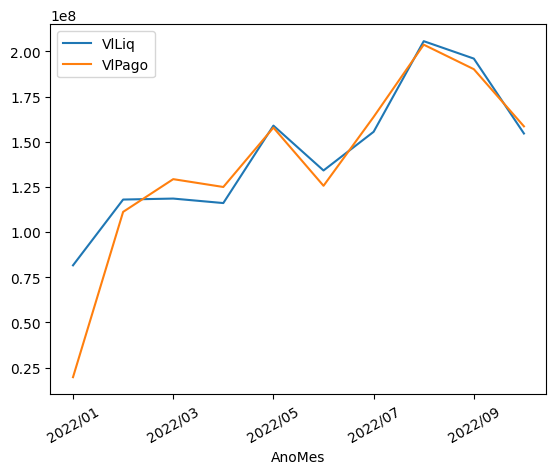

In [8]:
dfMinComunic = df[df['OrgaoSup']=='Ministério das Comunicações'].\
    groupby(['AnoMes','OrgaoSup','Despesa']).sum().reset_index()
    
dfMinComunic.groupby(['AnoMes', 'OrgaoSup']).sum().reset_index().\
    plot(x='AnoMes', y=['OrgaoSup', 'VlLiq', 'VlPago'],
                  kind="line", rot=30)

plt.show()

Pois bem, vamos descobrir quais as top 3 despesas que mais tiveram aumento em comparação aos três primeiros meses contra os últimos três.

In [9]:
# Achando os valores para o primeiro trimestre
dfPriTri = dfMinComunic[(dfMinComunic['AnoMes']=='2022/01') | \
                        (dfMinComunic['AnoMes']=='2022/02') | \
                        (dfMinComunic['AnoMes']=='2022/03')]\
                            [['Despesa', 'VlPago']].\
                    groupby('Despesa').sum()

# Achando os valores para o último trimestre
dfUltTri = dfMinComunic[(dfMinComunic['AnoMes']=='2022/08') | \
                        (dfMinComunic['AnoMes']=='2022/09') | \
                        (dfMinComunic['AnoMes']=='2022/10')]\
                            [['Despesa', 'VlPago']].\
                    groupby('Despesa').sum()

# novo DF com a apresentação dos trimestres (1º e último)
df_Trimestres = pd.merge(dfPriTri, dfUltTri, how='inner', on=['Despesa'])

df_Trimestres.head()

,VlPago_x,VlPago_y
Despesa,,
"Aposentadorias do RPPS, Reserva Remunerada e",3998438.52,5665264.01
Auxílio-Alimentação,2228093.99,3895569.40
Auxílio-Transporte,130849.29,365734.04
Contratação por Tempo Determinado,21310.20,1510764.36
Contribuição a Entidades Fechadas de Previdên,2102473.74,3433740.31


Vamos agora calcular quanto cada valor representa, em termos percentuais, do valor total em cada trimestre e, então, calcular a diferença entre eles.

In [10]:
df_Trimestres['%PriTri'] = (df_Trimestres['VlPago_x'] /
                  df_Trimestres['VlPago_x'].sum()) * 100

df_Trimestres['%UltTri'] = (df_Trimestres['VlPago_y'] /
                  df_Trimestres['VlPago_x'].sum()) * 100

df_Trimestres['%Dif'] = df_Trimestres['%UltTri'] - \
    df_Trimestres['%PriTri']

df_Trimestres.sort_values('%Dif', axis=0, ascending=False, inplace=True)

Assim, vemos que houve um aumento de 55% para 'Outros Serviçoes de Terceiros - Pessoa Jurídic'

In [11]:
df_Trimestres[:3]#.plot(x='Despesa', y=['VlPago_x', 'VlPago_y'])

,VlPago_x,VlPago_y,%PriTri,%UltTri,%Dif
Despesa,,,,,
Outros Serviços de Terceiros - Pessoa Jurídic,26972997.47,172012271.39,10.37,66.11,55.74
Serviços de Tecnologia da Informação e Comuni,25148841.64,63435313.51,9.66,24.38,14.71
Vencimentos e Vantagens Fixas - Pessoal Civil,107210864.25,144958197.07,41.20,55.71,14.51
